# GeophPy Tutorial: Advanced Data Processing

This notebook demonstrates the core geophysical filtering and processing steps available in `geophpy`. We will take a raw, interpolated dataset and apply a sequence of filters to clean it and enhance archaeological features.

**By the end of this tutorial, you will know how to:**
* Apply a threshold filter to remove extreme values.
* Correct for line shifts using a destaggering filter.
* Remove sensor-related stripes with a destriping filter.
* Enhance local contrast with a Wallis filter.

In [1]:
# --- Imports ---
from geophpy import Survey
import geophpy
import matplotlib.pyplot as plt
import os

# Displays the version to check the environment
print(f"Using GeophPy version: {geophpy.__version__} from: {geophpy.__date__}")

Using GeophPy version: 0.35.O from: 15/09/2025


geophpy.core.io - INFO - Reader returned point data. Populating survey.points...
geophpy.core.io - INFO - Data loaded from '..\data\Mag_ex1.dat' into Survey object 'Mag_ex1'.


..\data\Mag_ex1.dat
** {'x': 0, 'y': 1, 'values': 4}
Successfully created Survey object: 'Mag_ex1'
Successfully created and interpolated Survey object: 'Mag_ex1'


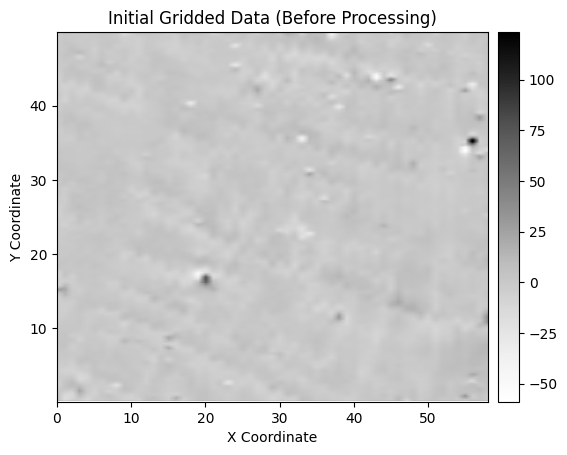

PointData(x=array([58, 58, 58, ...,  0,  0,  0], shape=(12450,)), y=array([49.887, 49.662, 49.437, ...,  0.631,  0.379,  0.126],
      shape=(12450,)), values=array([6.88 , 3.965, 2.031, ..., 5.715, 6.889, 7.614], shape=(12450,)), east=array([], dtype=float64), north=array([], dtype=float64), long=array([], dtype=float64), lat=array([], dtype=float64), track=array([], dtype=float64))


In [ ]:
# --- Load the Data ---
data_dir = os.path.join('..', 'data')
data_file = 'Mag_ex1.dat'
filepath = os.path.join(data_dir, data_file)
print(filepath)

column_map = {'x': 0,
              'y': 1,
              'values': 4
              }

survey = Survey.from_file(
    filepath,
    #delimiter=',',
    skiprows=1,
    column_map=column_map
)

if survey:
    print(f"Successfully created Survey object: '{survey.name}'")

# Interpolate to create the grid we will be processing
if survey:
    survey.interpolate(x_step=0.15, y_step=0.15)
    print(f"Successfully created and interpolated Survey object: '{survey.name}'")
    
    # Display the initial, unprocessed grid
    fig, ax = survey.plot('2D-SURFACE', title='Initial Gridded Data (Before Processing)')
    plt.show()


# if 'survey' in locals() and survey.grid:
#     #valmin, valmax = -20, 20
    
#     survey.plot_summary()
#     plt.show()

### 1. Threshold Filter

Our first processing step is to apply a threshold. It will clip any extreme values that might be noise, ensuring they don't negatively impact subsequent filters. We'll use the `threshold_grid` method for this.

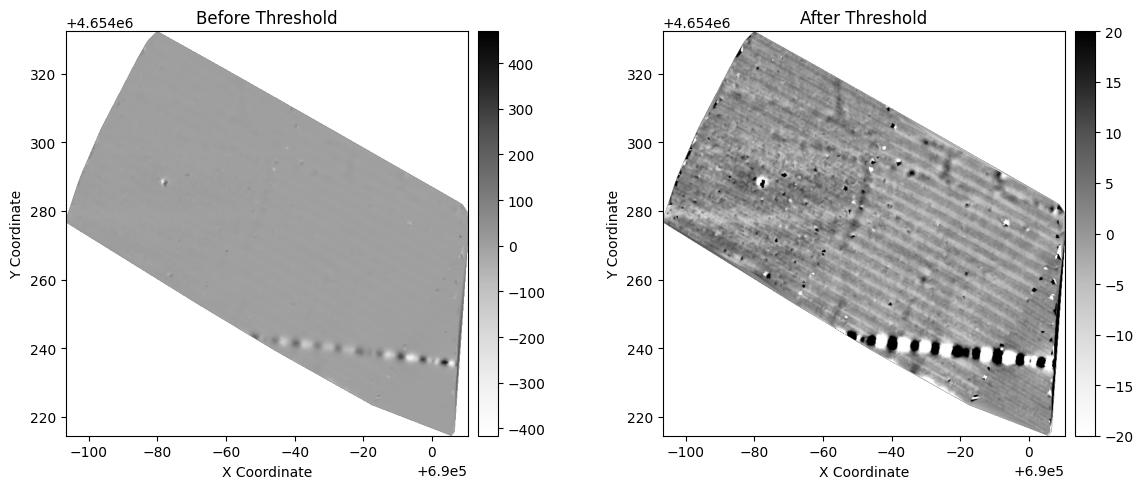

In [ ]:
if survey.grid:
    # We use the inplace=False pattern to see the "before" and "after"
    thresholded_survey = survey.threshold_grid(vmin=-20, vmax=20, fill_value='clip')

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    survey.plot('2D-SURFACE', ax=ax1, title='Before Threshold')
    thresholded_survey.plot('2D-SURFACE', ax=ax2, title='After Threshold')
    plt.tight_layout()
    plt.show()

### 2. Testing the Grid-Based  Despike Filter (`despike_1D_grid`)

First, let's test the filter that works on our interpolated grid. We will apply the filter and visualize the result side-by-side to see the effect. We'll use the `'hampel'` method.

Grid Data Statistics for 'Mag_ex2':
  - Min: -416.26
  - Max: 469.65
  - Mean: 0.62
  - Stdev: 17.34
Grid Data Statistics for 'Mag_ex2':
  - Min: -318.15
  - Max: 338.14
  - Mean: 0.60
  - Stdev: 16.43


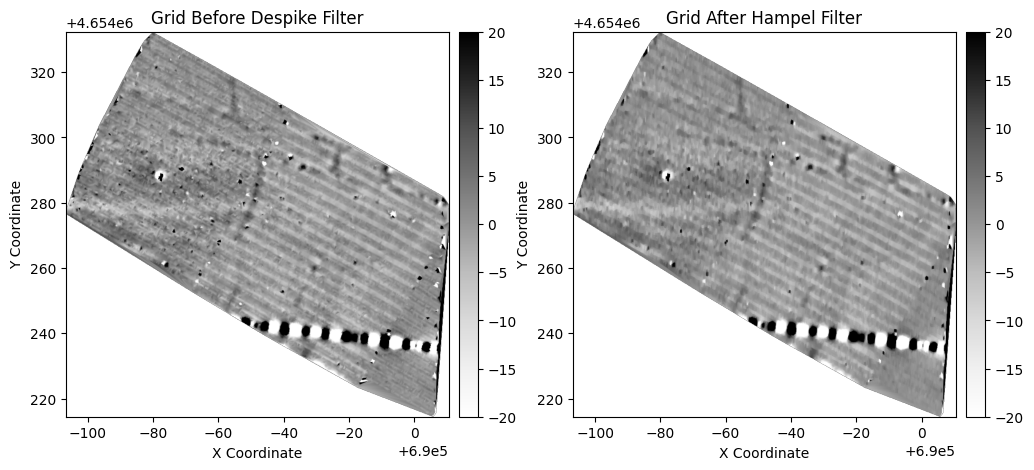

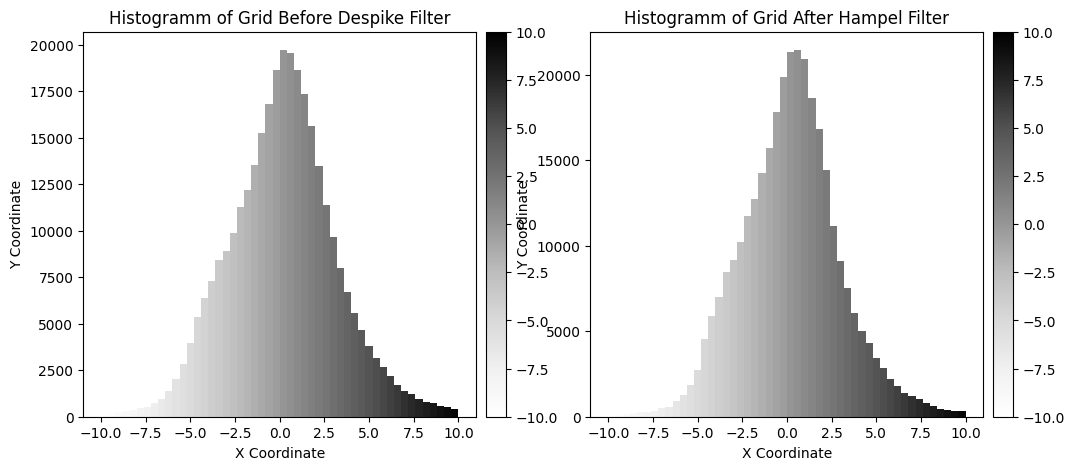

In [ ]:
if survey and survey.grid:
    # Apply the despike filter to the gridded data
    grid_stats = survey.get_grid_stats(verbose=True)
   
    filtered_survey_grid = survey.despike_1D_grid(
        method='hampel', 
        window_size=9, 
        threshold=0.0
    )

    filt_grid_stats = filtered_survey_grid.get_grid_stats(verbose=True)

    # Visualize the before and after
    valmin, valmax = -20, 20 
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Grid Before Despike Filter', vmin=valmin, vmax=valmax)
    filtered_survey_grid.plot('2D-SURFACE', ax=ax2, title='Grid After Hampel Filter', vmin=valmin, vmax=valmax)

    # Use the convenient shortcut method
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    survey.plot_grid_histogram(fig=fig, ax=ax1, cmap=survey.info.cmapname, 
                               range=(-10, 10)
                               )
    ax1.set_title("Histogramm of Grid Before Despike Filter")

    filtered_survey_grid.plot_grid_histogram(fig=fig, ax=ax2, cmap=survey.info.cmapname,
                               range=(-10, 10)
                               )
    ax2.set_title("Histogramm of Grid After Hampel Filter")

    #survey.save_figure(fig, 'my_final_map.png', dpi=300)

    plt.show()

### 2. Testing the Point-Based Despike Filter (`despike_1D_points`)

Now, let's test the filter that works on the raw, ungridded points. This method operates on a track-by-track basis.

To see the result, we will:
1. Apply the filter to the original point data.
2. Interpolate the *newly filtered* point data.
3. Compare the resulting grid to the original.

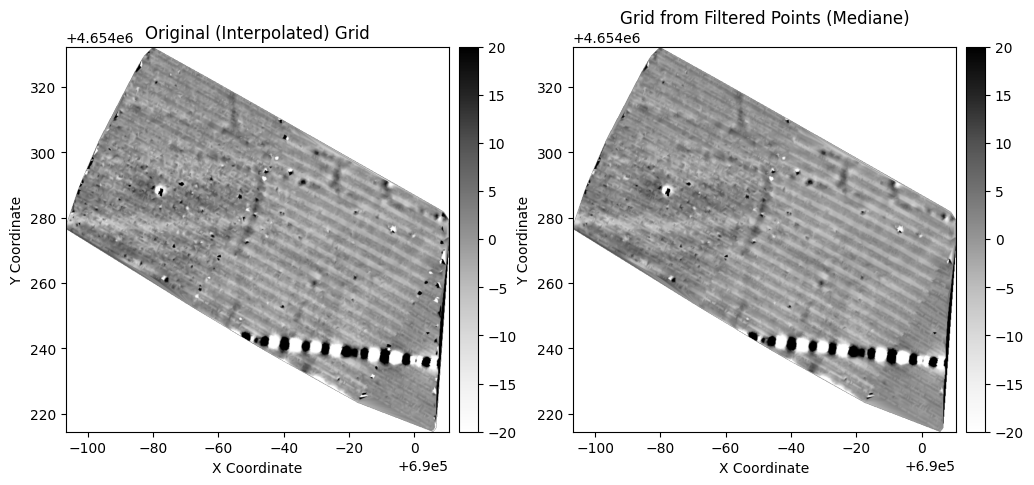

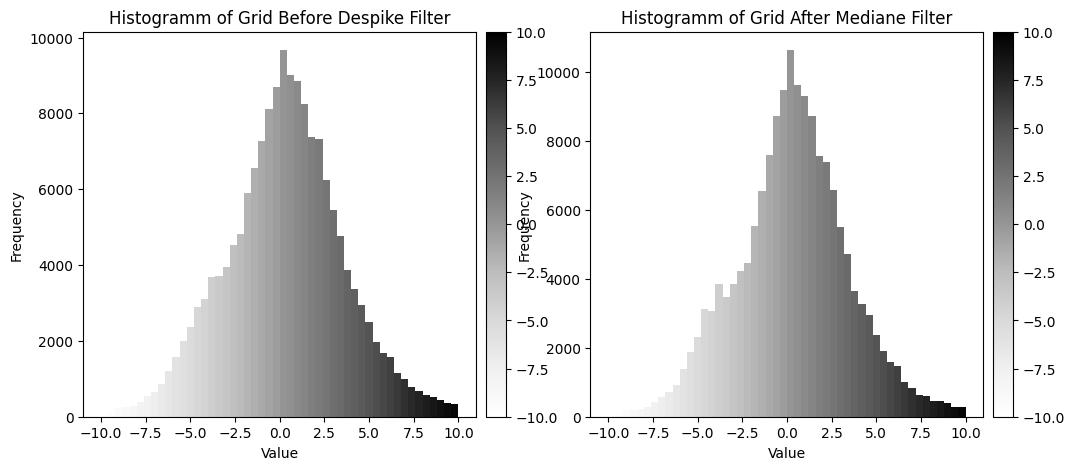

In [ ]:
if survey and survey.points:
    try:
        # Apply the peak filter to the point data
        valmin, valmax = -20, 20 
        filtered_survey_points = survey.despike_1D_points(
            method='hampel', 
            window_size=9,
            threshold=0.0 # Using a different threshold for demonstration
        )

        # Interpolate the filtered points to create a new grid
        filtered_survey_points.interpolate(x_step=0.15, y_step=0.15)

        # Visualize the before and after
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        survey.plot('2D-SURFACE', 
                    ax=ax1,
                    title='Original (Interpolated) Grid',
                    vmin=valmin, vmax=valmax)

        filtered_survey_points.plot('2D-SURFACE',
                                    ax=ax2,
                                    title='Grid from Filtered Points (Mediane)',
                                    vmin=valmin, vmax=valmax)
        
        # Use the convenient shortcut method
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
        survey.plot_points_histogram(fig=fig, ax=ax1, cmap=survey.info.cmapname, 
                                range=(-10, 10)
                                )

        ax1.set_title("Histogramm of Grid Before Despike Filter")

        filtered_survey_points.plot_points_histogram(fig=fig, ax=ax2, cmap=survey.info.cmapname,
                                range=(-10, 10)
                                )
        ax2.set_title("Histogramm of Grid After Mediane Filter")

        plt.show()

    except ValueError as e:
        print(f"Could not run point filter test: {e}")
        print("Note: This test requires track data to be present in the survey object.")

### 6. 2D Filtering (Despiking)

While 1D filters are great for profile-based noise, 2D filters operate on a moving window (e.g., 3x3 pixels) across the entire grid. They are very effective at removing "salt-and-pepper" noise or other isolated spikes.

We will test the two main 2D filters we've implemented: the decision-theoretic median filter and the Hampel filter.

#### 6a. 2D Median Decision Filter

The `median_filter_2d_grid()` method replaces a pixel with the median of its neighborhood, but *only* if the pixel's value differs from that median by a certain `threshold`. This is more subtle than a standard median filter.

--- Point Data Stats ---
Grid Data Statistics for 'Mag_ex2':
  - Min: -416.26
  - Max: 469.65
  - Mean: 0.62
  - Stdev: 17.34
Grid Data Statistics for 'Mag_ex2':
  - Min: -337.22
  - Max: 379.45
  - Mean: 0.58
  - Stdev: 15.91


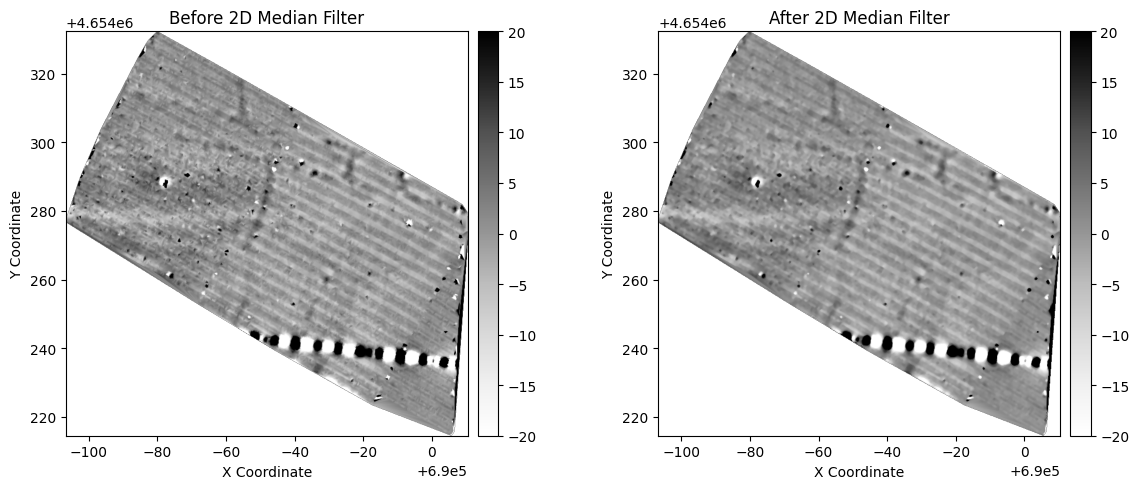

In [ ]:
if 'survey' in locals() and survey.grid:
    valmin, valmax = -20, 20 
    # Apply the 2D median decision filter
    median_2d_survey = survey.median_filter_2d_grid(
        window_size=(5, 5), 
        threshold=.02,  # Replace pixels that deviate by more than XX%
        mode='relative'
    )
    # Get statistics from the raw point data
    print("--- Point Data Stats ---")
    grid_stats = survey.get_grid_stats(verbose=True)
    filtered_stats = median_2d_survey.get_grid_stats(verbose=True)

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before 2D Median Filter', vmin=valmin, vmax=valmax)
    median_2d_survey.plot('2D-SURFACE', ax=ax2, title='After 2D Median Filter', vmin=valmin, vmax=valmax)
    
    plt.tight_layout()
    plt.show()

#### 6b. 2D Hampel Filter

The `hampel_filter_2d_grid()` is a more statistically robust filter. It replaces a pixel if it deviates from its local median by more than a certain number of Median Absolute Deviations (MADs). This makes it very good at identifying outliers without needing to know the exact noise level beforehand.

--- Point Data Stats ---
Grid Data Statistics for 'Mag_ex2':
  - Min: -416.26
  - Max: 469.65
  - Mean: 0.62
  - Stdev: 17.34
Grid Data Statistics for 'Mag_ex2':
  - Min: -379.06
  - Max: 414.08
  - Mean: 0.56
  - Stdev: 16.24


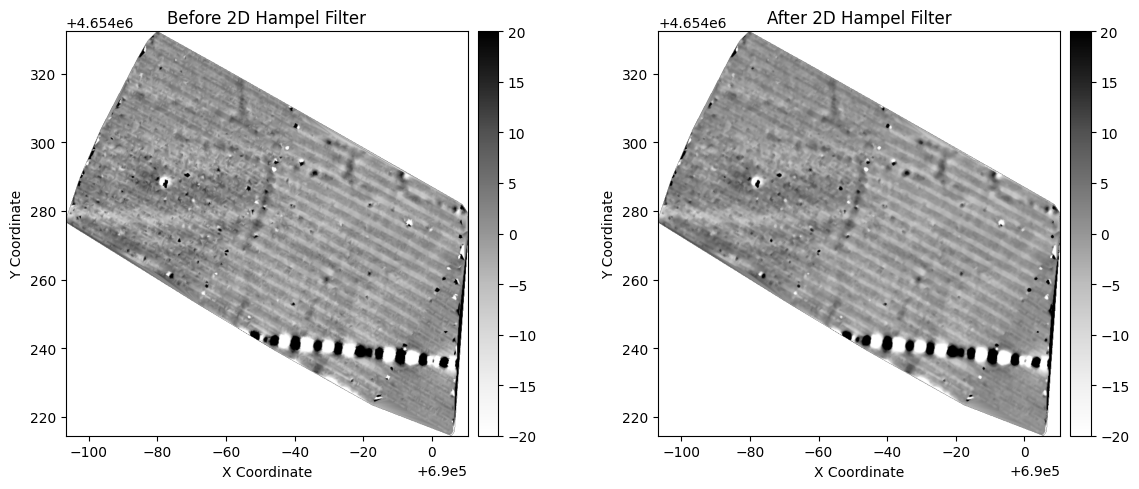

In [ ]:
if 'survey' in locals() and survey.grid:
    valmin, valmax = -20, 20 
    # Apply the 2D Hampel filter
    hampel_2d_survey = survey.hampel_filter_2d_grid(
        window_size=(5, 5), 
        threshold=1.0  # A standard value: replace pixels > 3 standard deviations (estimated by MAD)
    )
    
    # Get statistics from the raw point data
    print("--- Point Data Stats ---")
    grid_stats = survey.get_grid_stats(verbose=True)
    filtered_stats = hampel_2d_survey.get_grid_stats(verbose=True)

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before 2D Hampel Filter', vmin=valmin, vmax=valmax)
    hampel_2d_survey.plot('2D-SURFACE', ax=ax2, title='After 2D Hampel Filter', vmin=valmin, vmax=valmax)
    
    plt.tight_layout()
    plt.show()

### 5. Destriping Filters

Striping is a common artifact in geophysical data, often caused by minor variations between sensors or drift over time. It appears as linear features along the survey profiles. `geophpy` provides powerful methods to level the profiles and remove these stripes.

#### 5a. Destriping by Leveling (`destripe_grid_by_leveling`)

This method is the simplest approach. It calculates a statistic (like the mean or median) for each profile and adjusts it to match a global statistic for the entire survey. This is very effective for removing simple offsets between lines.

--- Point Data Stats ---
Grid Data Statistics for 'Mag_ex2':
  - Min: -416.26
  - Max: 469.65
  - Mean: 0.62
  - Stdev: 17.34
Grid Data Statistics for 'Mag_ex2':
  - Min: -407.27
  - Max: 460.80
  - Mean: 0.62
  - Stdev: 16.65


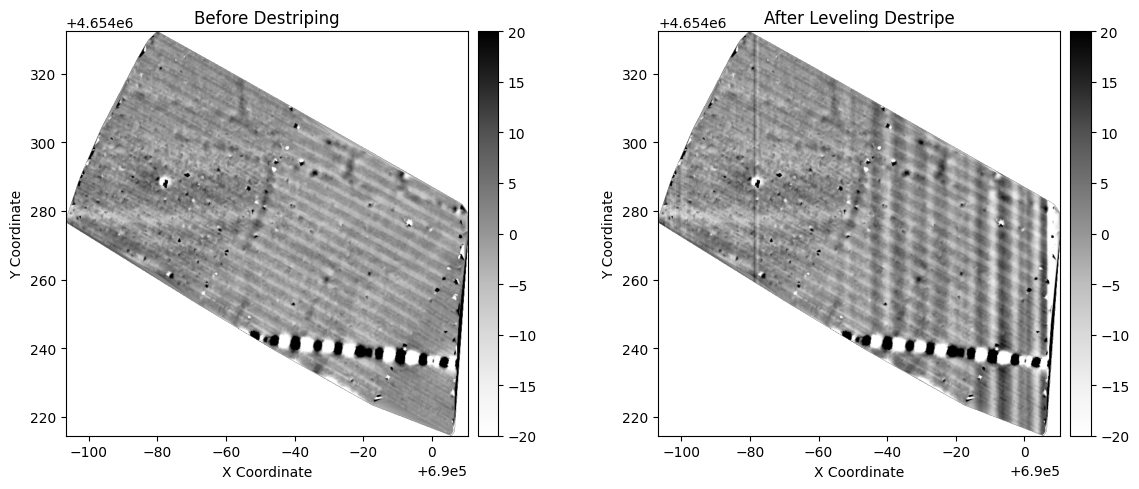

In [ ]:
if 'survey' in locals() and survey.grid:
    valmin, valmax = -20, 20
    # Apply the leveling destripe filter
    destriped_survey = survey.destripe_grid_by_leveling(
        reference='mean', 
        config='mono'
    )
    # Get statistics from the raw point data
    print("--- Point Data Stats ---")
    grid_stats = survey.get_grid_stats(verbose=True)
    filtered_stats = destriped_survey.get_grid_stats(verbose=True)

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before Destriping', vmin=valmin, vmax=valmax)
    destriped_survey.plot('2D-SURFACE', ax=ax2, title='After Leveling Destripe', vmin=valmin, vmax=valmax)
    
    plt.tight_layout()
    plt.show()

#### 5b. Destriping by Polynomial (`destripe_grid_by_polynomial`)

A more advanced method is to remove a long-wavelength trend from each profile by fitting a polynomial. This is very effective at removing both simple offsets and more complex, low-frequency noise along the survey lines.

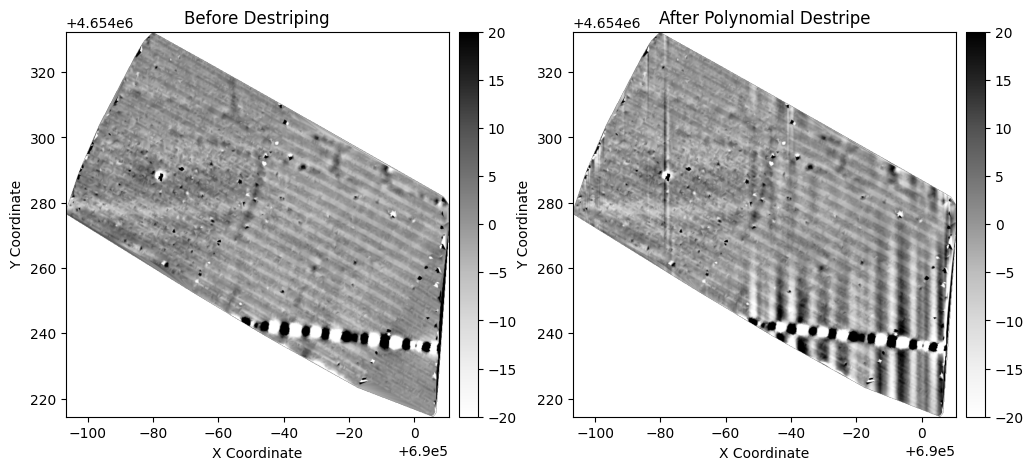

In [ ]:
if 'survey' in locals() and survey.grid:
    valmin, valmax = -20, 20
    # Apply the polynomial destripe filter
    destriped_poly_survey = survey.destripe_grid_by_polynomial(
        degree=2, # A 1st degree polynomial (linear trend)
        reference_poly='zero' # Subtract each profile's own trend
    )

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before Destriping', vmin=valmin, vmax=valmax)
    destriped_poly_survey.plot('2D-SURFACE', ax=ax2, title='After Polynomial Destripe', vmin=valmin, vmax=valmax)
    
    plt.show()

#### 5C. Zero mean and Zero median profiles (`zero_mean_tracks`, `zero_mean_tracks`)

A more advanced method is to remove a long-wavelength trend from each profile by fitting a polynomial. This is very effective at removing both simple offsets and more complex, low-frequency noise along the survey lines.

In [ ]:
if 'survey' in locals() and survey.points:
    valmin, valmax = -20, 20
    # Apply zero mean track
    print(survey.points.track)
    zero_mean_survey = survey.zero_mean_tracks()
    zero_mean_survey.interpolate(x_step=0.15, y_step=0.15)

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    survey.interpolate(x_step=0.15, y_step=0.15)
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before Destriping', vmin=valmin, vmax=valmax)
    survey.interpolate(x_step=0.15, y_step=0.15)
    zero_mean_survey.plot('2D-SURFACE', ax=ax2, title='After Zero Mean Track', vmin=valmin, vmax=valmax)
    
    # Apply zero median track
    zero_median_survey = survey.zero_median_tracks()
    zero_median_survey.interpolate(x_step=0.15, y_step=0.15)

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before Destriping', vmin=valmin, vmax=valmax)
    zero_median_survey.plot('2D-SURFACE', ax=ax2, title='After Zero Median Track', vmin=valmin, vmax=valmax)
    
    plt.show()

[]


ValueError: Survey has no track data to process.

### 4. Trend Separation (`ProcessingMixin`)

A powerful technique in geophysical data processing is the separation of regional and local trends. This allows you to either remove a large-scale regional gradient to highlight small, local features, or to study the regional trend itself. The `separate_grid_trends()` method is designed for this purpose.

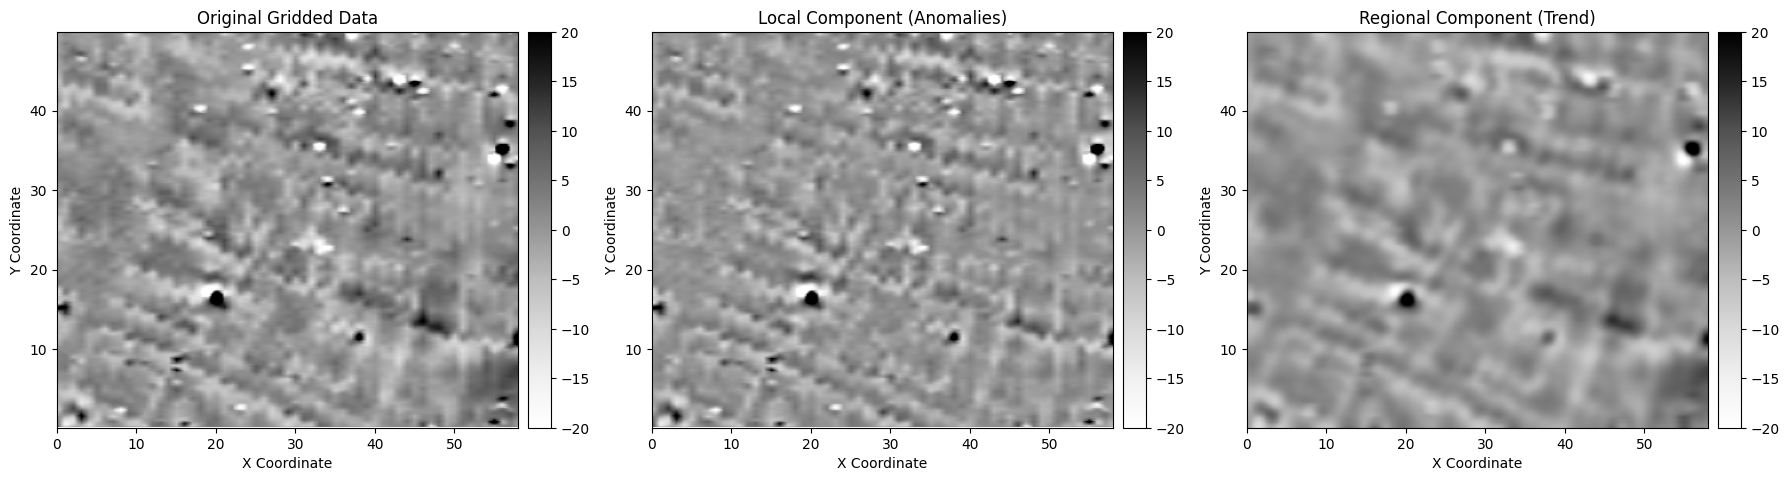

In [ ]:
if survey.grid:
    valmin, valmax = -20, 20
    # --- Separate the survey into its local and regional components ---
    
    # 1. Extract the local component (high-pass filter)
    local_survey = survey.separate_grid_trends(
        window_size=(29, 29), 
        component='local'
    )

    # 2. Extract the regional component (low-pass filter)
    regional_survey = survey.separate_grid_trends(
        window_size=(11, 11), 
        component='regional'
    )

    # --- Visualize all three components for comparison ---
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Original Gridded Data', vmin=valmin, vmax=valmax)
    
    local_survey.plot('2D-SURFACE', ax=ax2, title='Local Component (Anomalies)', vmin=valmin, vmax=valmax)

    regional_survey.plot('2D-SURFACE', ax=ax3, title='Regional Component (Trend)', vmin=valmin, vmax=valmax)
    
    plt.tight_layout()
    plt.show()

### 2. Destaggering Filter (`festoonfilt`)

Next, we correct the "festoon" or staggering effect, which comes from slight misalignments between survey lines. The `festoonfilt_grid` method realigns the profiles.

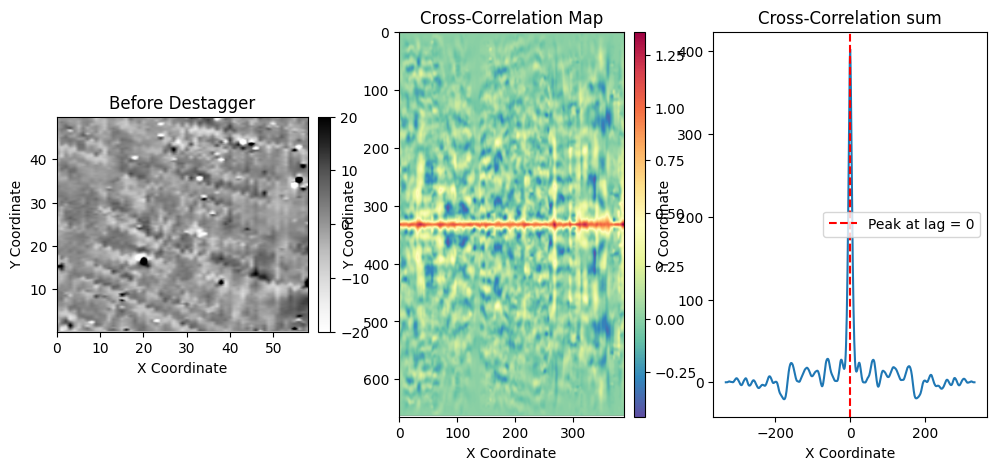

In [ ]:
if 'survey' in locals() and survey.grid:
    valmin, valmax = -20, 20
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
    survey.plot_correlation_map(ax=ax2, title='Cross-Correlation Map')
    survey.plot_correlation_sum(ax=ax3, title='Cross-Correlation sum')
    survey.plot('2D-SURFACE', ax=ax1, title='Before Destagger', vmin=valmin, vmax=valmax)
    plt.show()



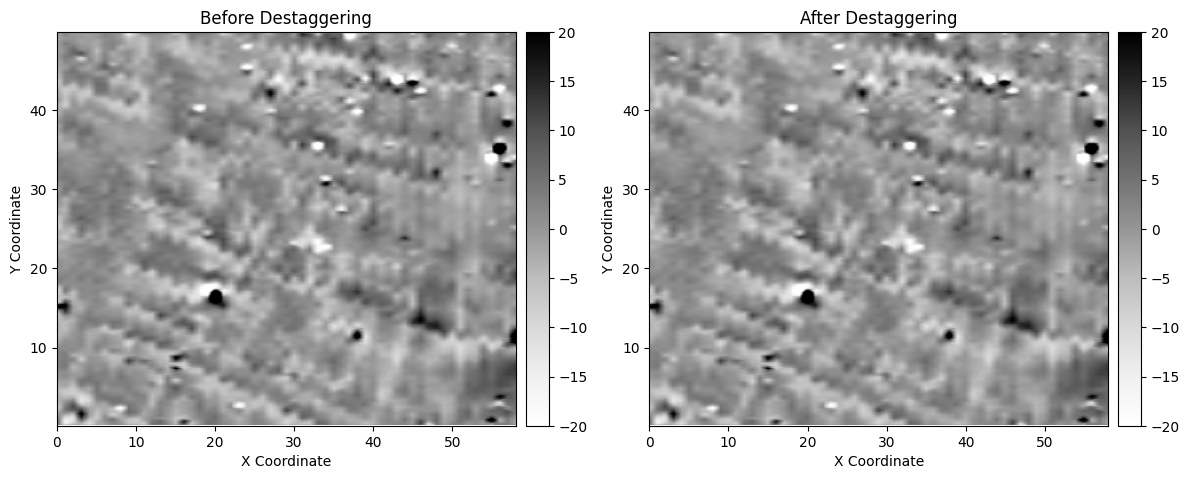

In [ ]:
if 'survey' in locals() and survey.grid:
    valmin, valmax = -20, 20
#    destaggered_survey = survey.destagger_grid()
#    destaggered_survey = survey.destagger_grid_by_correlation()

    destaggered_survey = survey.destagger_points_by_track()
    destaggered_survey.interpolate(x_step=0.15, y_step=0.15)


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    survey.plot('2D-SURFACE', ax=ax1, title='Before Destaggering', vmin=valmin, vmax=valmax)
    destaggered_survey.plot('2D-SURFACE', ax=ax2, title='After Destaggering', vmin=valmin, vmax=valmax)

    plt.tight_layout()
    plt.show()

### 7. Contrast Enhancement Filters

The final step in many processing workflows is to enhance the local contrast of the grid to make subtle features more visible. We have implemented two powerful filters for this purpose: the Wallis filter and CLAHE.

#### 7a. Wallis Filter

The `wallis_filter_grid()` method is an adaptive filter that aims to make the mean and standard deviation uniform across the image. It is excellent for balancing the brightness and contrast of the entire map.

In [ ]:
if 'survey' in locals() and survey.grid:
    # Apply the Wallis filter
    wallis_survey = survey.wallis_filter_grid(
        window_size=(21, 21) # A larger window considers more of the regional trend
    )

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before Wallis Filter')
    wallis_survey.plot('2D-SURFACE', ax=ax2, title='After Wallis Filter')
    
    plt.tight_layout()
    plt.show()

#### 7b. CLAHE Filter (Contrast Limited Adaptive Histogram Equalization)

The `clahe_filter_grid()` method is another advanced technique that works by improving contrast in smaller, local regions (or "tiles") of the image. It is particularly effective at revealing fine textures and details that might otherwise be hidden.

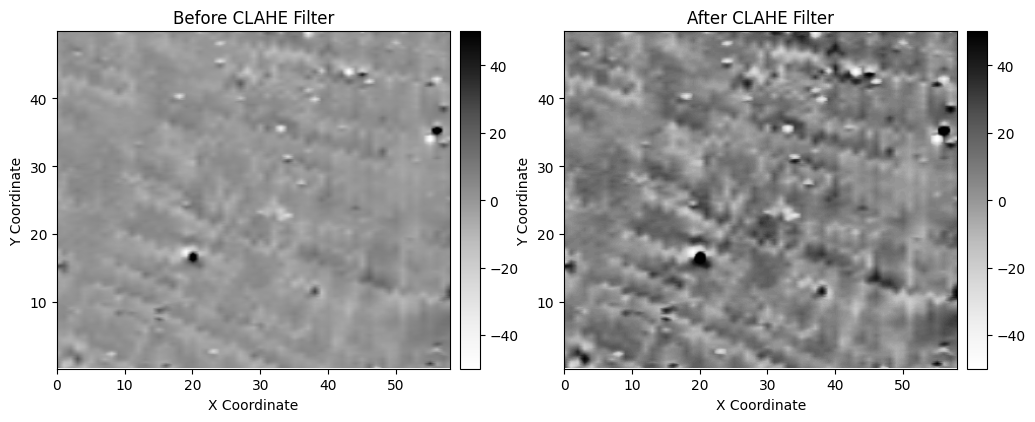

In [ ]:
if 'survey' in locals() and survey.grid:
    valmin, valmax = -50, 50
    # Apply the CLAHE filter
    clahe_survey = survey.clahe_filter_grid(
        clip_limit=0.01 # This is a key parameter to control the contrast
    )

    # Visualize the before and after
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    survey.plot('2D-SURFACE', ax=ax1, title='Before CLAHE Filter', vmin=valmin, vmax=valmax)
    clahe_survey.plot('2D-SURFACE', ax=ax2, title='After CLAHE Filter', vmin=valmin, vmax=valmax)
    
#    plt.tight_layout()
    plt.show()